In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
from scipy import stats
from functools import reduce
from scipy.stats import pearsonr

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'

In [2]:
my_colors = {'NL_18':'tan', 
             'NL_25':'goldenrod', 
             'NL_27':'gold', 
             'FXS_421':'lightblue', 
             'FXS_426':'cornflowerblue', 
             'FXS_470':'b',
             'FXS_448':'purple'}
genotype_order = ('NL_18', 
             'NL_25', 
             'NL_27', 
             'FXS_421', 
             'FXS_426', 
             'FXS_470',
             'FXS_448')

In [3]:
NL_18_CGG = pd.read_csv('CGG_count/b.n.176.txt', sep='\t', header=None)
NL_27_CGG = pd.read_csv('CGG_count/b.n.barcode01.txt', sep='\t', header=None)
NL_25_CGG = pd.read_csv('CGG_count/158.txt', sep='\t', header=None)
FXS_421_CGG = pd.read_csv('CGG_count/b.n.135.txt', sep='\t', header=None)
FXS_426_CGG = pd.read_csv('CGG_count/b.n.fsw.txt', sep='\t', header=None)
FXS_470_CGG = pd.read_csv('CGG_count/b.n.barcode03.txt', sep='\t', header=None)
mmFXS_CGG = pd.read_csv('CGG_count/b.n.gmo.txt', sep='\t', header=None)
NL_18_CGG['Genotype'] = 'NL_18'
NL_27_CGG['Genotype'] = 'NL_27'
NL_25_CGG['Genotype'] = 'NL_25'
FXS_421_CGG['Genotype'] = 'FXS_421'
FXS_426_CGG['Genotype'] = 'FXS_426'
FXS_470_CGG['Genotype'] = 'FXS_470'
mmFXS_CGG['Genotype'] = 'FXS_448'
CGG_counts = pd.concat([NL_18_CGG, NL_25_CGG, NL_27_CGG,
                        FXS_421_CGG, FXS_426_CGG, FXS_470_CGG, 
                        mmFXS_CGG], ignore_index=True)
CGG_counts = CGG_counts.rename(columns={1: 'CGG_count'})

/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57072/2450144831.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  f = sns.swarmplot(data=CGG_counts.query("Genotype == 'FXS_421' | Genotype == 'FXS_426' | Genotype == 'FXS_470' | Genotype == 'FXS_448'"),
/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57072/2450144831.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=CGG_counts.query("Genotype == 'FXS_421' | Genotype == 'FXS_426' | Genotype == 'FXS_470' | Genotype == 'FXS_448'"),
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warni

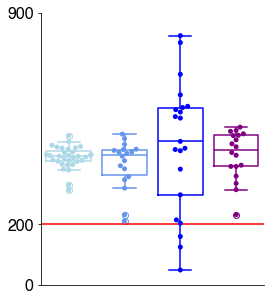

In [4]:
plt.figure(figsize=(4, 5))
f = sns.swarmplot(data=CGG_counts.query("Genotype == 'FXS_421' | Genotype == 'FXS_426' | Genotype == 'FXS_470' | Genotype == 'FXS_448'"),
                  x='Genotype', y='CGG_count', palette=my_colors,
                 size=5)
sns.boxplot(data=CGG_counts.query("Genotype == 'FXS_421' | Genotype == 'FXS_426' | Genotype == 'FXS_470' | Genotype == 'FXS_448'"), 
            x='Genotype', y='CGG_count', palette=my_colors, fill=False)
plt.axhline(y=200, color='red')
plt.ylim(0, 900)
plt.yticks([0,200,900], fontsize=16)
f.set(xlabel=None)
f.set(ylabel=None)
f.set_xticks([])
f.spines['top'].set_visible(False)
f.spines['right'].set_visible(False)
#f.figure.savefig('Nanopore_CGG_count_FXS_4.pdf',dpi=1000)

In [5]:
NL_18_np = pd.read_csv('nanopolish/176.tsv', sep='\t')
NL_27_np = pd.read_csv('nanopolish/barcode01.tsv', sep='\t')
NL_25_np = pd.read_csv('nanopolish/158.tsv', sep='\t')
FXS_421_np = pd.read_csv('nanopolish/135.tsv', sep='\t')
FXS_426_np = pd.read_csv('nanopolish/fsw.tsv', sep='\t')
FXS_470_np = pd.read_csv('nanopolish/barcode03.tsv', sep='\t')
combined_df_GM0 = pd.read_csv('nanopolish/9497_nanopolish.tsv', sep='\t')
nanopolish = pd.concat([NL_18_np, NL_25_np, NL_27_np, 
                        FXS_421_np,FXS_426_np,FXS_470_np,
                        combined_df_GM0,
                       ], ignore_index=True)
strique = pd.read_csv('strique.txt', sep='\t')
strique_4 = strique[(strique['score_prefix'] > 4) & (strique['score_suffix'] > 4)]
CGG_count_nanopolish = pd.merge(CGG_counts, nanopolish, left_on=0, right_on='read_name', how='inner')
CGG_count_nanopolish_filtered = CGG_count_nanopolish[CGG_count_nanopolish['read_name'].isin(strique_4['read_name'])]

In [8]:
#CpGisland analysis 
#chrX:147911574-147912682
CpGisland = CGG_count_nanopolish_filtered[(CGG_count_nanopolish_filtered['start'] > 147911574) 
                                  & (CGG_count_nanopolish_filtered['end'] < 147912682)]
read_name_counts = CpGisland['read_name'].value_counts()
CpGisland['read_name_count'] = CpGisland['read_name'].map(read_name_counts)
CpGisland['methyl_bool_int'] = (CpGisland['log_lik_ratio']>.1).astype(int)
CpGisland['promoter_methylation_count'] = CpGisland.groupby('read_name')['methyl_bool_int'].transform('sum')
CpGisland['promoter_methylation_denom'] = CpGisland.groupby('read_name')['num_calling_strands'].transform('sum')

/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57072/4016103205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CpGisland['read_name_count'] = CpGisland['read_name'].map(read_name_counts)
/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57072/4016103205.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CpGisland['methyl_bool_int'] = (CpGisland['log_lik_ratio']>.1).astype(int)
/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57072/4016103205.py:8: SettingWithCopyWarning:

In [9]:
CpGisland_trimmed=CpGisland[[
 'CGG_count',
 'Genotype',
 'read_name',
 'promoter_methylation_count',
    'promoter_methylation_denom']].drop_duplicates()
CpGisland_trimmed['promoter_methylation_%'] = (CpGisland_trimmed['promoter_methylation_count']/CpGisland_trimmed['promoter_methylation_denom']) * 100

/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_57072/4168757385.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=CpGisland_trimmed,


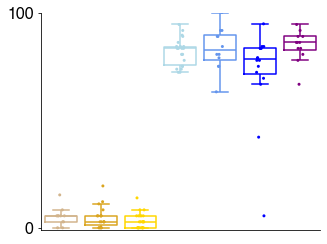

In [10]:
plt.figure(figsize=(5, 4))
s=sns.stripplot(data=CpGisland_trimmed,
    x='Genotype', y='promoter_methylation_%', hue='Genotype',palette=my_colors, 
              size=3)
sns.boxplot(data=CpGisland_trimmed, 
            x='Genotype', y='promoter_methylation_%', palette=my_colors, fill=False,
           showfliers=False)
plt.ylim(-1,100)
plt.yticks([0,100], fontsize=16)
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([]) 
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#s.figure.savefig('Nanopore_promoter_methylation.pdf',dpi=1000)
plt.show()

In [11]:
RNAseq = pd.read_csv('DESEQ_melted.txt', sep='\t')
rna_mean = RNAseq.query("gene_name == 'FMR1'").groupby(['Genotype', 'gene_name'])['value'].mean().unstack()
cpg_mean = CpGisland_trimmed.groupby('Genotype')['promoter_methylation_%'].mean()
rna_mean_df = rna_mean.reset_index()
cpg_mean_df = cpg_mean.reset_index()
rna_methylation_df = pd.merge(rna_mean_df, cpg_mean_df, on='Genotype')

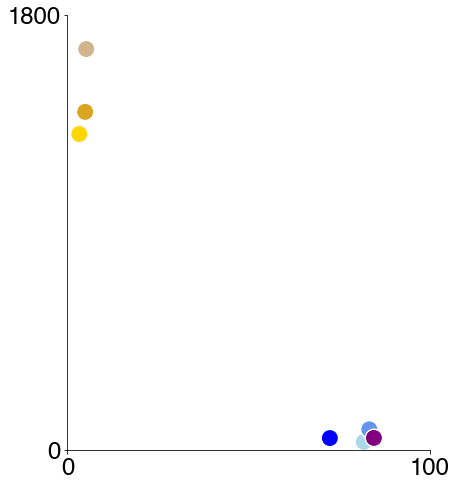

In [13]:
plt.figure(figsize=(6.5, 8))
s=sns.scatterplot(data=rna_methylation_df,
    hue='Genotype', x='promoter_methylation_%', y='FMR1',
                  palette=my_colors,s=300, legend=False)
pearson_corr, _ = pearsonr(rna_methylation_df['promoter_methylation_%'], rna_methylation_df['FMR1'])
#plt.annotate(f'ρ ={pearson_corr:.2f}', xy=(0.75, 1), xycoords='axes fraction', 
#             fontsize=30, ha='center', va='top')
plt.ylim(0,1800)
plt.yticks([0,1800], fontsize=24)
plt.xticks([0,100], fontsize=24)
plt.xlim(0,100)
s.set(xlabel=None)
s.set(ylabel=None)
#s.legend(loc=1)
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#s.figure.savefig('Nanopore_promoter_methylation_vs_FMR1.pdf',dpi=1000)
plt.show()